In [3]:
#All these packages need to be installed from pip
import gensim #For word2vec, etc
import requests #For downloading our datasets
#import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas as pd#Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

import re

# 1 Get the corpora

In [2]:
mis_df = pd.read_csv("tweets_small.csv")
mis_df_small = mis_df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
mis_df_small.head()

,Datetime,Tweet Id,Text,User,User_location,Place,Coordinates,Keyword
0,2021-06-15 17:05:20+00:00,1404847502331990018,“bitch what r u doing out there without me” ht...,_lindssss,NJ,NaN,NaN,bitch
1,2021-06-15 09:48:15+00:00,1404737509549121536,"What's worse, that grin of his yawns about as ...",catullusbot,Ancient Rome,NaN,NaN,cunt
2,2021-01-20 12:53:06+00:00,1351875400692101123,Omg yo my future wife prolly giving a nigga th...,Coopavelli_,443,NaN,NaN,pussy
3,2021-01-20 05:29:38+00:00,1351763797065740289,Any bitch I bring out gonna have the time of h...,FalonRonae,Why? We never linking.,NaN,NaN,bitch
4,2021-06-15 03:46:15+00:00,1404646407231852545,Chrissy Teigen has always been that unfunny re...,authenticduke,All Over Los Angeles,NaN,NaN,bitch ass


# 2 Tokenization

In [5]:
import spacy
nlp = spacy.load("en_core_web_sm")

def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):
    
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner", "lemmatizer"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized
    
def normalizeTokens(word_list, extra_stop=[], model=nlp, lemma=True, MAX_LEN=1500000):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        list_tmp = []
        for elem in word_list:
            list_tmp.append(elem)
        word_list = ' '.join(list_tmp) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "tagger", "ner"])

    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    # we check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(w.lemma_)
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(w.text.strip())

    return normalized


In [6]:
def sent_tokenize(word_list, model=nlp):
    doc = model(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

In [7]:
mis_df_small['tokenized_sents'] = mis_df_small['cleaned_text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
mis_df_small['normalized_sents'] = mis_df_small['tokenized_sents'].apply(lambda x: [normalizeTokens(s) for s in x])

C:\Users\liqiu\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [8]:
misW2V = gensim.models.word2vec.Word2Vec(mis_df_small['normalized_sents'].sum(), sg=0)

In [11]:
misW2V.wv.most_similar('woman')

[('ucking', 0.998742938041687),
 ('ick', 0.9986869692802429),
 ('pussies', 0.9985202550888062),
 ('takes', 0.998462438583374),
 ('ave', 0.9984195828437805),
 ('enjoy', 0.9983705878257751),
 ('girls', 0.9983689785003662),
 ('feels', 0.9983376264572144),
 ('shame', 0.9982975721359253),
 ('balls', 0.9982428550720215)]

In [12]:
misW2V.wv.most_similar('man')

[('fine', 0.997022807598114),
 ('place', 0.9969719052314758),
 ('cool', 0.9969708919525146),
 ('somebody', 0.9968761205673218),
 ('turn', 0.9967746138572693),
 ('find', 0.9967357516288757),
 ('ike', 0.99672532081604),
 ('ok', 0.9965589642524719),
 ('friend', 0.9965091347694397),
 ('screen', 0.9964550137519836)]

In [18]:
import random
n = random.randint(0,30000)
mis_df_small['cleaned_text'][n]

' ominating betas is what   was born to do   ont miss out on a genuine domme cause you re a pussy     indom paypig  indomme brutal whalesub human    relapse cbt  beta betas cuck fincuck cuckold '

In [27]:
numWords = 50

mistargetWords = misW2V.wv.index_to_key[:numWords]
miswordsSubMatrix = []
for word in mistargetWords:
    miswordsSubMatrix.append(misW2V.wv[word])
miswordsSubMatrix = np.array(miswordsSubMatrix)

In [23]:
mispcaWords = sklearn.decomposition.PCA(n_components = 50).fit_transform(miswordsSubMatrix)

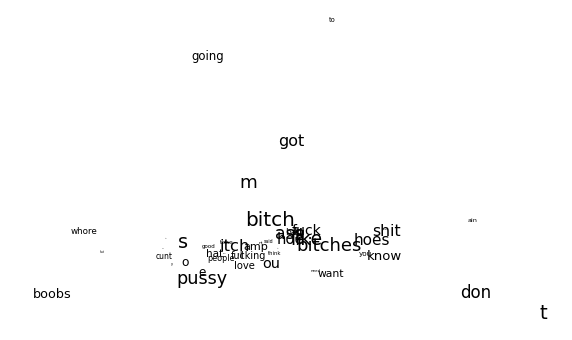

In [28]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(mispcaWords[:, 0], mispcaWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(mistargetWords):
    ax.annotate(word, (mispcaWords[:, 0][i],mispcaWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

C:\Users\liqiu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\liqiu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


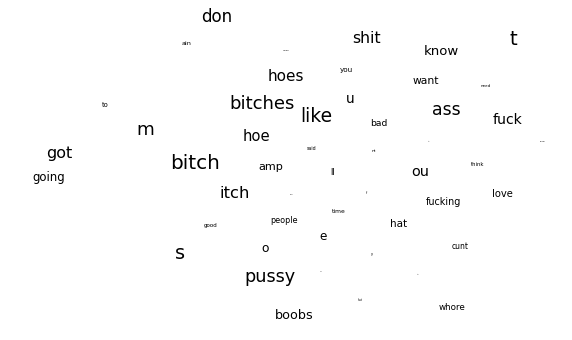

In [29]:
mistsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(mispcaWords)
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(mistsneWords[:, 0], mistsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(mistargetWords):
    ax.annotate(word, (mistsneWords[:, 0][i],mistsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()